In [1]:
import tensorflow as tf
import os
from PIL import Image

## Data loading and processing

The first steps are to load in the AKOA image data and then convert them to an appropriate format for learning. Because of the face we're on Tf v2.1, the only way I could figure out how to do this was using the tf.data.Dataset methods. The idea is we specify which directory to look inside for the images, and then call a series of functions which converts the image paths into tensors.

In [2]:
HEIGHT, WIDTH = 228, 260
DATA_DIR = 'h:/COMP3710/AKOA_Analysis'

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # Extract LEFT/RIGHT data from filename
    parts = tf.strings.split(parts[-1], '.')
    parts = tf.strings.split(parts[0], '_')
    pattern = tf.constant("right")
    
    is_right = pattern == tf.strings.lower(parts[-1])
    return tf.cast(is_right, dtype='float32')

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=1)
    img = tf.cast(img, dtype='float32')
    # cast and scale the tensor
    img = tf.math.truediv(img, tf.constant(255.0))
    
    return img #tf.image.resize(img, [HEIGHT, WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def configure_for_performance(dataset, batch_size=32):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset
        
# Data processing
def load_knee_data(path):
    dataset = tf.data.Dataset.list_files(f"{path}/*.png")
    
    data_count = len(os.listdir(path))
    VALIDATION_SPLIT = 0.2
    VALIDATION_SIZE = int(VALIDATION_SPLIT * data_count)

    training_data = dataset.skip(VALIDATION_SIZE)
    testing_data = dataset.take(VALIDATION_SIZE)

    print("Training set cardinality:", tf.data.experimental.cardinality(training_data).numpy())
    print("Validation set cardinality:", tf.data.experimental.cardinality(testing_data).numpy())
    
    # map the filenames to image/label pairs for learning
    training_data = training_data.map(process_path, 
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    testing_data = testing_data.map(process_path, 
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # configure the datasets to make them efficient to learn with
    training_data = configure_for_performance(training_data)
    testing_data = configure_for_performance(testing_data)
    
    print("Training set cardinality:", tf.data.experimental.cardinality(training_data).numpy())
    print("Validation set cardinality:", tf.data.experimental.cardinality(testing_data).numpy())

    return training_data, testing_data

training_data, testing_data = load_knee_data(DATA_DIR)

Training set cardinality: 14944
Validation set cardinality: 3736
Training set cardinality: 467
Validation set cardinality: 117


## Build the Model

In [15]:
def generate_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(HEIGHT, WIDTH, 1)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

model = generate_model()


In [16]:
def bool_dice_coefficient(ground_truth, predicted):
    intersection = tf.keras.backend.sum(ground_truth * predicted)
    
    return ((2.0 * intersection) / (tf.keras.backend.sum(ground_truth * ground_truth)
      + tf.keras.backend.sum(predicted * predicted)))

def dice_coefficient(ground_truth, predicted):
    intersection = tf.keras.backend.sum(ground_truth * predicted)
    
    return ((2.0 * intersection) / (tf.keras.backend.sum(ground_truth)
      + tf.keras.backend.sum(predicted)))


def dice_coefficient_loss(ground_truth, predicted):
    return 1.0 - dice_coefficient(ground_truth, predicted)

In [17]:
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.fit(
    training_data,
    epochs=40,
    #batch_size=128,
    shuffle=True,
    validation_data=testing_data,
    callbacks=[tf.keras.callbacks.TensorBoard()]
)

Train for 467 steps, validate for 117 steps
Epoch 1/40
467/467 [==============================] - 14s 30ms/step - loss: 0.1253 - accuracy: 0.9449 - val_loss: 0.0281 - val_accuracy: 0.9890
Epoch 2/40
467/467 [==============================] - 13s 29ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 1.8480e-04 - val_accuracy: 1.0000
Epoch 3/40
467/467 [==============================] - 13s 29ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 7.1449e-04 - val_accuracy: 0.9997
Epoch 4/40
467/467 [==============================] - 13s 29ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 4.9844e-04 - val_accuracy: 1.0000
Epoch 5/40
467/467 [==============================] - 13s 28ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 4.0267e-05 - val_accuracy: 1.0000
Epoch 6/40
467/467 [==============================] - 13s 29ms/step - loss: 9.0170e-06 - accuracy: 1.0000 - val_loss: 3.3600e-05 - val_accuracy: 1.0000
Epoch 7/40
467/467 [==============================] - 13s 29ms/step 

KeyboardInterrupt: 

# Time for some predictions

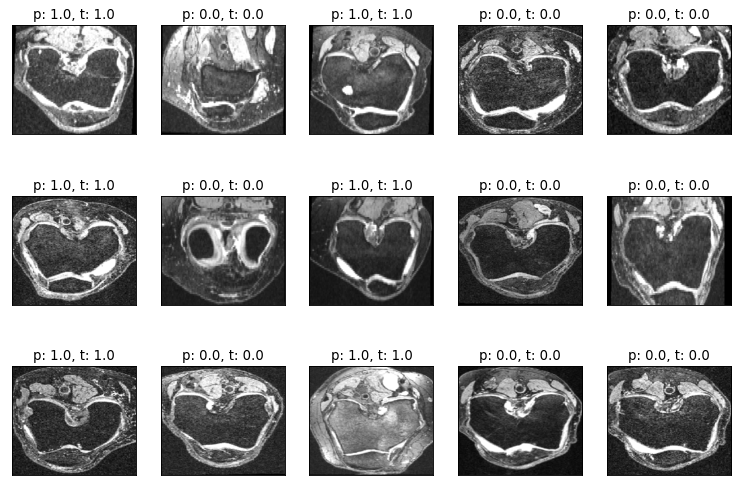

In [59]:
import matplotlib.pyplot as plt

def show_results(model, images_per_row, rows):
    for images, labels in testing_data.cache().repeat().take(1):
        predictions = model.predict(images[:images_per_row + 1])
        plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

        for i in range(1, len(predictions)):
            for j in range(rows):
                ax = plt.subplot(3, len(predictions), i + j * len(predictions))
                ax.set_title(f"p: {round(predictions[i, 0], 1)}, t: {labels[i].numpy()}")
                plt.imshow(tf.reshape(images[i + j * len(predictions)], (HEIGHT, WIDTH)))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

show_results(model, 5, 3)

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 226, 258, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 113, 129, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 111, 127, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 53, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 24960)            

In [55]:
model.save_weights('./checkpoints/result')

In [ ]:
model2 = 